# Classification - With 4 MONAI Models

 Classification of brain tumors with MONAI. To accelerate training, 2D dataset is used based on the 3D one.


## Dataset

We use the Decathlon 3D Brain Tumor dataset and create a 2D version by combining slices with tumors and healthy slices without tumors. You can download the pre-processed dataset from Google Drive.


##  MONAI is installed


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import gdown" || pip install -q "gdown"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.4 MB/s eta 0:00:00


##  Import libraries

In [3]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import torch
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

monai.config.print_config()

# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set deterministic training for reproducibility
set_determinism(seed=42)

MONAI version: 1.5.dev2446
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 218216250ce297265400abe56ee915898d75a2ec
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.66.6
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.46.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

In [4]:
# figure out if we're running in Google Colab. Set paths accordingly.
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    best_model_folder = "/content/drive/MyDrive/saved_models/"
    os.makedirs(best_model_folder, exist_ok=True)
except:
    best_model_folder = ""

best_model_path = os.path.join(best_model_folder, "best_model_2d_glioma_classification.pth")

Mounted at /content/drive


In [5]:
best_model_path1 = os.path.join(best_model_folder, "best_model_2d_glioma_classification1.pth")
best_model_path2 = os.path.join(best_model_folder, "best_model_2d_glioma_classification2.pth")
best_model_path3 = os.path.join(best_model_folder, "best_model_2d_glioma_classification3.pth")

## Setup data

Specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  

### 2D data

We'll download the pre-computed dataset from Google Drive.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/tmp/tmplr0smm9t


In [7]:
download_from_gdrive = True
task = "Task01_BrainTumour"
output_dir = os.path.join(root_dir, task + "2D")

if download_from_gdrive:
    resource = "https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download"
    md5 = "214a338a26778c84ddebca29822add56"
    compressed_file = os.path.join(root_dir, task + "2D.tar")
    download_and_extract(resource, compressed_file, root_dir, hash_val=md5)
else:
    %run -i ../utils/2d_slice_creator.py --path {output_dir} --download_path {root_dir} --task {task}
    pass

# get all the 2d images
images_healthy = glob(os.path.join(output_dir, "image_healthy", "*.nii.gz"))
images_tumour = glob(os.path.join(output_dir, "image_tumour", "*.nii.gz"))
data_dicts = []
data_dicts += [{"image": i, "label": [1, 0]} for i in images_healthy]
data_dicts += [{"image": i, "label": [0, 1]} for i in images_tumour]

# shuffle the data and sort into training and validation
train_files, val_files = partition_dataset(data_dicts, ratios=(8, 2), shuffle=True)
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))

Downloading...
From (original): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E
From (redirected): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&confirm=t&uuid=cb95dca6-a07f-4e9c-a160-036be8c2fa50
To: /tmp/tmpkkapjwg2/Task01_BrainTumour2D.tar
100%|██████████| 122M/122M [00:07<00:00, 16.9MB/s]

2024-11-21 17:10:45,515 - INFO - Downloaded: /tmp/tmplr0smm9t/Task01_BrainTumour2D.tar


2024-11-21 17:10:45,736 - INFO - Verified 'Task01_BrainTumour2D.tar', md5: 214a338a26778c84ddebca29822add56.
2024-11-21 17:10:45,737 - INFO - Writing into directory: /tmp/tmplr0smm9t.
total num files: 968
num training files: 774
num validation files: 194


## Prepare for training -- create transforms, datasets, dataloaders


In [40]:
train_transforms = val_transforms = mt.Compose(
    [
        mt.LoadImaged("image"),
        mt.Rotate90d("image"),
        mt.Flipd(keys="image", spatial_axis=0),  # Flip along a spatial axis
        mt.RandGaussianNoised(keys="image", prob=0.2, mean=0.0, std=0.1),  # Add Gaussian noise randomly
        mt.CropForegroundd("image", source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(["image", "label"]),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` was changed in version 1.5 from `allow_smaller=True` to `allow_smaller=False`.
  warn_deprecated(argname, msg, warning_category)


In [41]:
num_workers = 2
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=10,
                          num_workers=num_workers, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(
    data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=10,
                        num_workers=num_workers, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 194/194 [00:01<00:00, 126.24it/s]


##  Displaying some scans

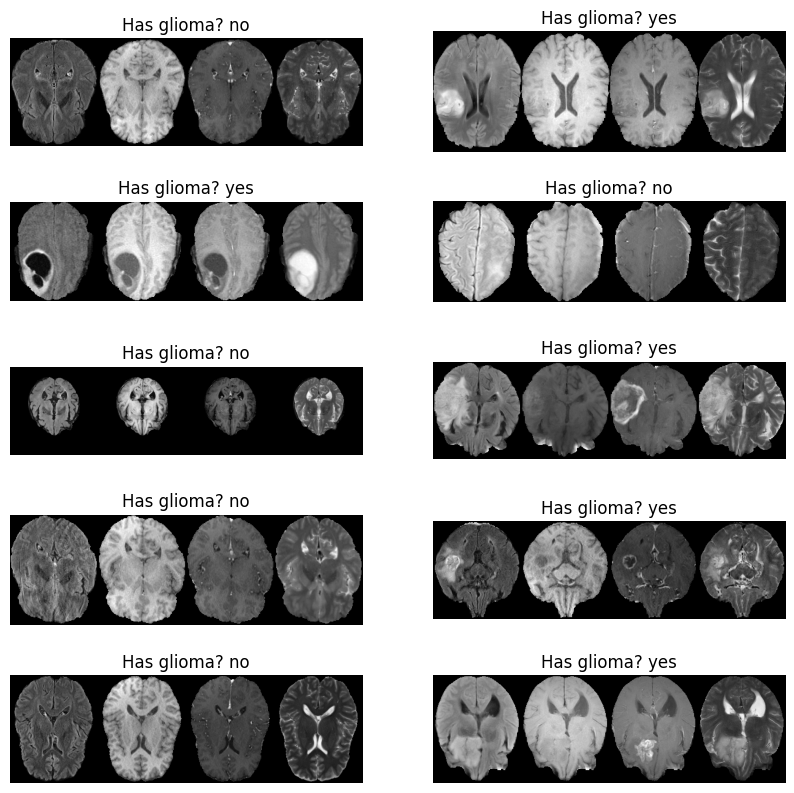

In [66]:
nrow, ncol = 5, 2
num_files = nrow * ncol
files_to_visualize = np.random.choice(train_files, size=num_files, replace=False)
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 10), facecolor='white')
for f, ax in zip(files_to_visualize, axes.flatten()):
    data = train_transforms(f)
    # different modalities side by side
    img = np.concatenate(list(data["image"]), axis=1)
    im_show = ax.imshow(img, cmap="gray")
    ax.set_title(f"Has glioma? {['yes', 'no'][data['label'][0]]}")
    ax.axis("off")

## Create the model, loss function, etc.

### The model

The following models are used:



*   EfficientNetBN
*   DenseNet121
*   DenseNet264
*   Resnet18








In [43]:
from monai.networks.nets import EfficientNetBN
model1 = EfficientNetBN(model_name="efficientnet-b0", spatial_dims=2, in_channels=4, num_classes=2)
model1.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 32.6MB/s]


EfficientNetBN(
  (_conv_stem): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (_blocks): Sequential(
    (0): Sequential(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_expand_conv_padding): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
        (_se_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (_se_reduce_padding): Identity()
        (_se_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand_padding): Identity()
        (

In [44]:
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()

In [45]:
model2 = monai.networks.nets.DenseNet264(spatial_dims=2, in_channels=4, out_channels=2)
model2.to(device)


loss_function = torch.nn.CrossEntropyLoss()

In [46]:
from monai.networks.nets import resnet18

model3 = resnet18(
    spatial_dims=2,
    n_input_channels=1,  # Change this to 1 to match the input data
    num_classes=2
)
model3.to(device)

import torch
loss_function = torch.nn.CrossEntropyLoss()



In [47]:
# Helper function for inferring during validation
def infer_seg(images, model):
    return model(images).argmax(0)


# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
optimizer1 = torch.optim.Adam(model1.parameters(), 1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), 1e-4)
optimizer3 = torch.optim.Adam(model3.parameters(), 1e-4)

# Train for all the models!

In [48]:
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses, metrics = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.nn.Softmax(dim=1)(outputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_path)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.3838, best val metric: 0.9639 at epoch 10: 100%|██████████| 10/10 [04:16<00:00, 25.64s/it]


In [49]:
# start a typical PyTorch training
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses1, metrics1 = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer1.zero_grad()
        outputs = model1(inputs)
        #print(f"Inputs shape: {inputs.shape}, Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
        outputs = torch.nn.Softmax(dim=1)(outputs)
        #print(f" Outputs shape after softmax: {outputs.shape}")
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer1.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses1.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model1):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model1(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics1.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model1.state_dict(), best_model_path1)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.3571, best val metric: 0.9175 at epoch 10: 100%|██████████| 10/10 [02:59<00:00, 17.94s/it]


In [52]:
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses2, metrics2 = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer2.zero_grad()
        outputs = model2(inputs)
        #print(f"Inputs shape: {inputs.shape}, Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
        outputs = torch.nn.Softmax(dim=1)(outputs)
        #print(f" Outputs shape after softmax: {outputs.shape}")
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer2.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses2.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model2):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model2(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics2.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model2.state_dict(), best_model_path2)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.3516, best val metric: 0.9794 at epoch 9: 100%|██████████| 10/10 [06:46<00:00, 40.61s/it]


In [61]:
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses3, metrics3 = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        #inputs = inputs.mean(dim=1, keepdim=True)
        inputs = inputs[:, 0:1, :, :]
        inputs, labels = inputs.to(device), labels.to(device)


        optimizer3.zero_grad()
        outputs = model3(inputs)
        #print(f"Inputs shape: {inputs.shape}, Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
        #outputs = torch.nn.Softmax(dim=1)(outputs)
        #print(f" Outputs shape after softmax: {outputs.shape}")
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer3.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses3.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model3):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_images = val_images[:, 0:1, :, :].clone().detach()  # Select only the first channel if multi-channel data
                with torch.no_grad():
                    val_outputs = model3(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics3.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model3.state_dict(), best_model_path3)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.1472, best val metric: 0.9381 at epoch 6: 100%|██████████| 10/10 [03:15<00:00, 19.52s/it]


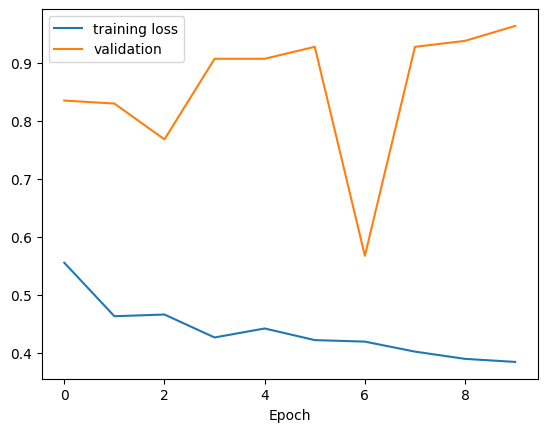

In [50]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses, label="training loss")
ax.plot(metrics, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()

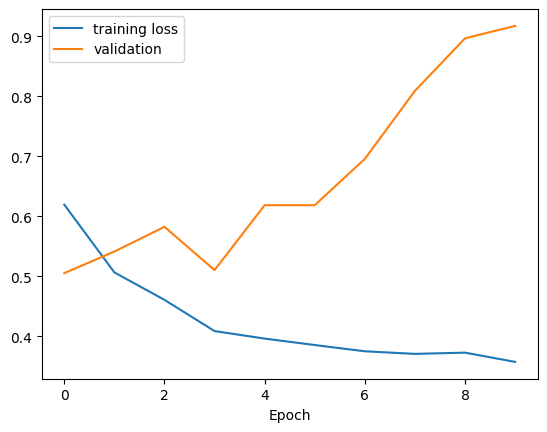

In [51]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses1, label="training loss")
ax.plot(metrics1, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()

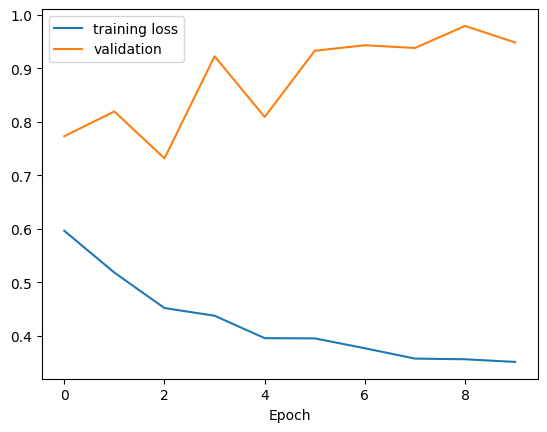

In [53]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses2, label="training loss")
ax.plot(metrics2, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()

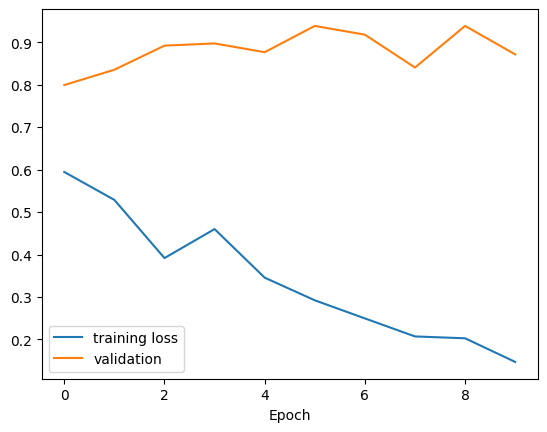

In [62]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses3, label="training loss")
ax.plot(metrics3, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()

In [54]:
model.load_state_dict(torch.load(best_model_path))
_ = model.eval()

<ipython-input-54-df4a6896f45c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [55]:
model1.load_state_dict(torch.load(best_model_path1))
_ = model1.eval()

<ipython-input-55-9fa681f0d540>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(best_model_path1))


In [56]:
model2.load_state_dict(torch.load(best_model_path2))
_ = model2.eval()

<ipython-input-56-4526aaf36dea>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(best_model_path2))


In [63]:
model3.load_state_dict(torch.load(best_model_path3))
_ = model3.eval()

<ipython-input-63-b5a1d529675f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load(best_model_path3))


# Confusion Matrices for Classification

We loop over validation files, and plot a confusion matrix.

100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


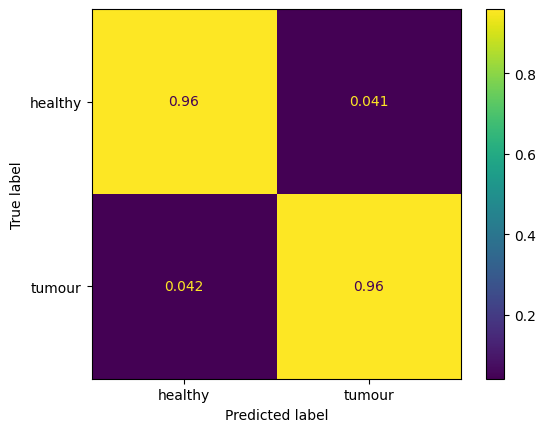

In [58]:
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

DenseNet121 is performing well for both healthy and tumour scans.

100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


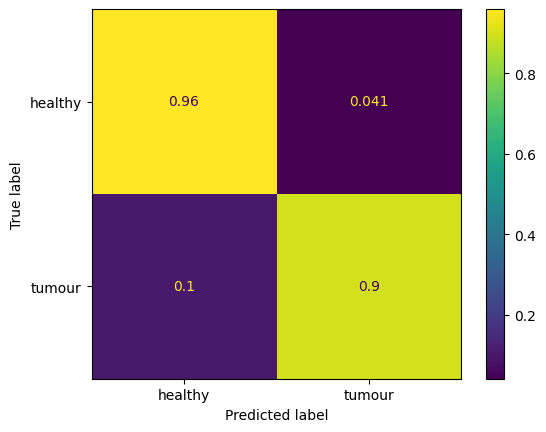

In [59]:
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model1(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

EfficientBN is performing better for Healthy than tumour scans. But both accuracies are good.

100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


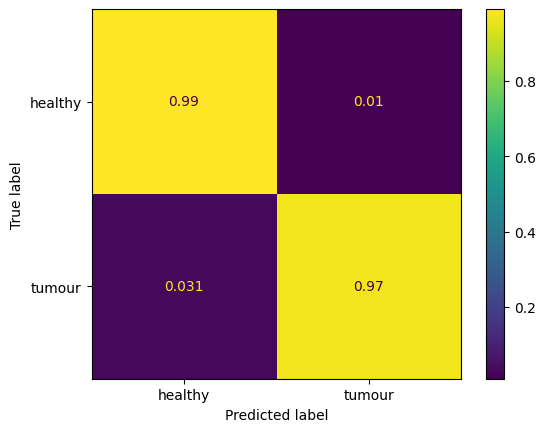

In [60]:
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model2(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

Dense264 is performing quite well for both healthy and tumour scans

100%|██████████| 20/20 [00:04<00:00,  4.60it/s]


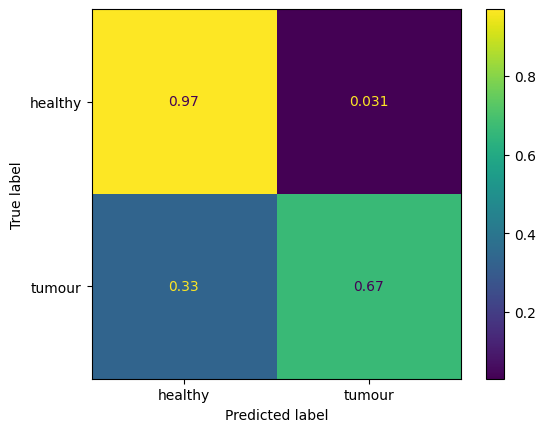

In [64]:
#ResNet18

y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    images = images.mean(dim=1, keepdim=True)
    outputs = model3(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

ResNet is accurately able to detect healthy scans in most cases but not tumour cases.

## Conclusion

The best model for this classification task is Model 2 i.e. DenseNet264.

Although the validaiton accuracy steadily increased and training loss steadily decreased for most of the models used, Densenet264 is more accurate than the rest.

The plateau of validation accuracy suggests overfitting and perhaps can be improved with more transforms in the data augmentation section.